## EE512 – Applied Biomedical Signal Processing
# Practical session – Linear Models II
### Instructions
* This notebook provides all the questions of the practical session and the space to answer them. We recommend working directly here and then exporting the document as your report.
* Include any code used when addressing the questions, together with your answers.
* Please submit your report as a single PDF file.
* We recommend working in a group of 3–4 students; you must prepare one single report for the group (`name1_name2_name3_lab_LinearModelsII.pdf`), but every member needs to upload the same file individually.

In [1]:
%matplotlib widget

# Imports
import os
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import resample, welch
from statsmodels.regression.linear_model import yule_walker

# File paths
fhr1 = os.path.join(os.getcwd(), 'data', 'heart_1.dat')
fhr2 = os.path.join(os.getcwd(), 'data', 'heart_2.dat')
fem1 = os.path.join(os.getcwd(), 'data', 'emg1.dat')
fem2 = os.path.join(os.getcwd(), 'data', 'emg2.dat')
fppg = os.path.join(os.getcwd(), 'data', 'ppg.dat')
feeg = os.path.join(os.getcwd(), 'data', 'eeg_stim.dat')

### Experiment 1: parametric spectral estimation of cardiorespiratory signals
The file `/data/heart_1.dat` contains three physiological signals: RR-interval, arterial pressure and respiration, in this order (sampled at 4 Hz). The recordings were made in a patient at rest. In the spectral domain, this RR-interval signal is expected to show a peak around 0.08 Hz, corresponding to the *baroreflex* (regulation between arterial blood pressure and heart rate), and a peak at 0.225 Hz, corresponding to the *breathing rate* (heart rhythm modulation by respiration, the so-called *“sinus arrhythmia”*) – see `/data/readme_heart.txt` for more details.

We start by importing the signals, subsampling to 1 Hz, and removing their averages:

In [2]:
with open(fhr1, 'r') as f:
    txt = f.readlines()
    txt = [s[:-1].split() for s in txt]
    
    rr1 = np.array([float(s[0]) for s in txt])
    bp1 = np.array([float(s[1]) for s in txt])
    rs1 = np.array([float(s[2]) for s in txt])

df = 4
rr1 = resample(rr1, int(len(rr1)/df))
bp1 = resample(bp1, int(len(bp1)/df))
rs1 = resample(rs1, int(len(rs1)/df))

for y in [rr1, bp1, rs1]:
    y -= np.mean(y)

AR modeling provides tools for extracting various useful estimates from a signal, in a so-called *parametric* way, because the estimates are based on the model parameters, rather than on the raw signal itself. The function defined below implements the estimation of the signal spectral density based on its AR parameters.

In [4]:
def ar_psd(arg1, arg2, arg3, n=1000):
    """
    Parametric spectral density estimation based on AR modeling
    
    Inputs:
        arg1: ?
        arg2: ?
        arg3: ?
        n: defines the spectral sampling
    
    Outputs:
        arg4: ?
        arg5: ?
    """
    
    arg5 = np.arange(n) * arg3/2/n
    aar, sg = yule_walker(arg1, order=arg2, method="mle")
    
    a = complex(1)
    for k in range(1,arg2+1):
        a += -aar[k-1] * np.exp(-2*np.pi*k*1j*arg5/arg3)
    
    arg4 = sg**2 / (arg3 * np.abs(a)**2)
    
    return arg4, arg5

**Question 1.1.** The implementation above has an incomplete docstring (help text), and the input and output arguments have generic names (`arg1-5`). Copy the function to the answer space below, complete the help, and replace the argument names by more intuitive choices, based on what you've learned in the theory.

In [7]:
#Answer 1.1.
def ar_psd(s, o, sf, num_points=1000):
    """
    Parametric spectral density estimation based on AR modeling
    
    Inputs:
        s: the input signal from which we are going to estimate its power spectral density. It will be an array-like input.
        o: order of the autoregressive model we will be using. It will be an int type input. 
        sf: sampling frequency with which we will sample the input signal. We can take it as a float type input.
        n: defines the spectral sampling (the number of spectral points we want to generate)
    
    Outputs:
        sd: the spectral density we have estimated for the input signal. Array-like type output.
        f: frequencies at which the power spectral density is estimated (frequencies at which we have distinct peaks, dominant frequencies)
    """
    
    #creating the frequency axis (we are transforming the num_points into Hz)
    f = np.arange(num_points) * (sf/2)/num_points
    
    #estimating the AR-parameters using the yule-walker method
    aar, sg = yule_walker(s, order=o, method="mle")
    
    #we are setting a complex value for the first parameter and we will calculate the rest in the following line (in the for loop)
    a = complex(1)
    
    for k in range(1,o+1):
        a += -aar[k-1] * np.exp(-2*np.pi*k*1j*f/sf)
        
    #Calculation of the spectral density using the AR parameters
    sd = sg**2 / (sf * np.abs(a)**2)
    
    return sd, f


We now use this tool to obtain the spectral density of the three signals. Below, we explore the results obtained with different AR model orders: 5, 15, 30.

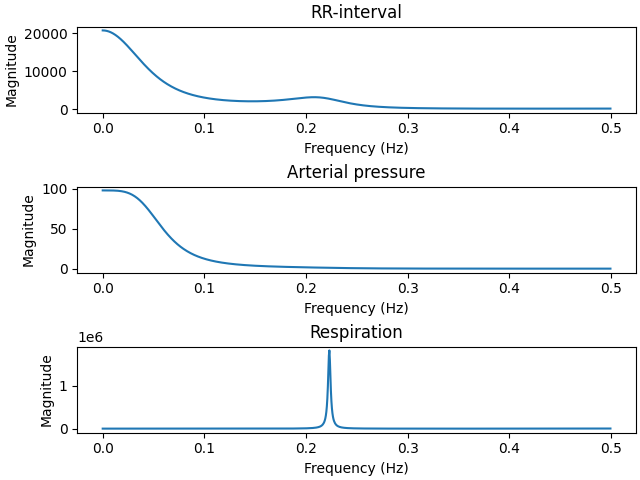

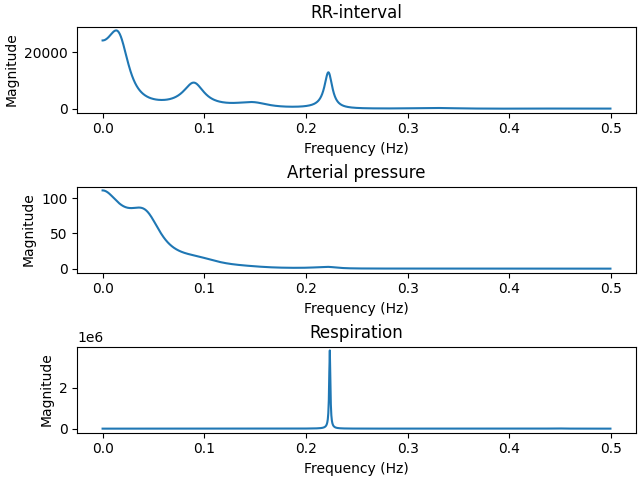

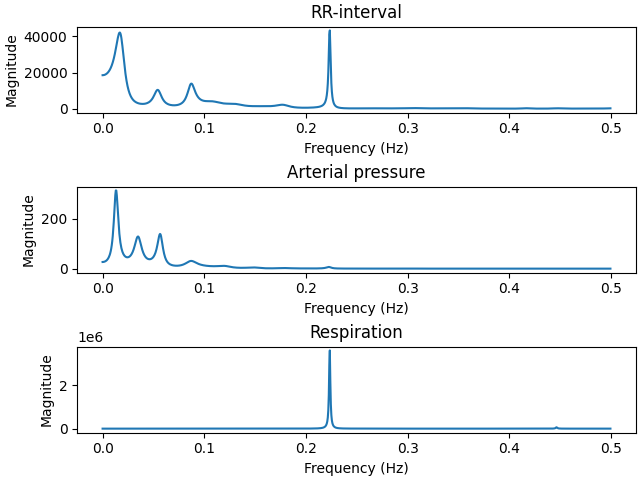

In [8]:
y = [rr1, bp1, rs1]
ttl = ['RR-interval', 'Arterial pressure', 'Respiration']

for p in (5, 15, 40):
    
    plt.figure(constrained_layout=True)
    
    for k in range(3):
        
        py, f = ar_psd(y[k], p, 1.0)
        
        plt.subplot(3,1,k+1)
        plt.plot(f, py)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.title(ttl[k])

**Question 1.2.** How does the order affect the spectra? Given the physiological description of the expected peaks for the RR-interval, what is the most suitable order choice?

**Answer 1.2.** `As mentioned in the heading of the exercise, the RR-interval signal is expected to show a peak around 0.08 Hz, corresponding to the baroreflex (regulation between arterial blood pressure and heart rate), and a peak at 0.225 Hz, corresponding to the breathing rate. We can observe that when we use a very low order, we will not have enough information about the signal to be able to distinguish the dominant frequencies. In the p=30 AR power spectrum density estimation we can completely distinguish the 0.225 Hz and the 0.08 Hz peaks. However, we have more peaks that may confuse us, as we might not necessarily know in the beginning the exact frequencies where we expect the physiological phenomena to occur. Therefore, the best estimation would be the one with p = 15. This order is likely to provide a good balance between capturing the expected physiological peaks and avoiding excessive sensitivity to noise.`

We can now perform a *non-parametric* spectral estimation of the same signals, using for instance Welch’s method:

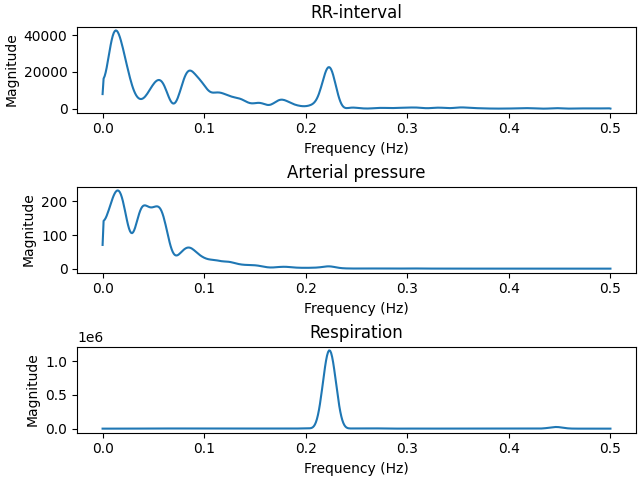

In [10]:
y = [rr1, bp1, rs1]
ttl = ['RR-interval', 'Arterial pressure', 'Respiration']

plt.figure(constrained_layout=True)

for k in range(3):
    
    f, py = welch(y[k], fs=1.0, nperseg=100, scaling='density', nfft=1000)
    
    plt.subplot(3,1,k+1)
    plt.plot(f, py)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title(ttl[k])

**Question 1.3.** Explain how Welch's method works (it may be helpful to consult the help of `welch`), and the fundamental differences between this approach and the AR parametric method.

**Answer 1.3.** `Welch is another method to estimate the power spectral density of a signal. It is a widely used non-parametric approach (a method that does not assume a specific mathematical model for the data under analysis). How does this method work? Firstly, it divides the signal into segments of data, typically overlapping segments. We will have to make sure that the overlapping percentage is enough, so that we don't lose information between adjacent signals. Then a window is applied to each segment to reduce spectral leakages due to the abrupt changes between segments of data. The windows are used in order to soften them. The FFT is applied on each segment in order to get some knowledge about the frequency in that specific segment. Then, the power spectral density or periodogram is calculated in each segment. Later, we will average all the power spectral densities we have calculated to obtain the final PSD estimate. This will help us to reduce the variance and obtain a more reliable spectral representation. Regarding the differences between the AR parametric method and the Welch approach, Welch's method doesn't rely on an underlying dta model, it is non-parametric unlike the AR method. Additionally, the AR method has a fixed complexity depending on the order. Welch's method is more flexible, due to the fact that you can adjust the segment length and overlap to inrease or diminish the spectral estimation detail. It provides more control over the trade-off between detail and noise in the spectral estimate because. Averaging across segments in Welch's method helps reduce the impact of noise and produces smoother spectra.
`

**Question 1.4.** In our particular problem, how do the spectra obtained with Welch's method compare with those of the parametric approach (order 15)? Given the previous RR-interval description, which approach performs most reliably?

**Answer 1.4.** `In the previous questions, we determined a model order of 15 as the most suitable representation for the Power Spectral Density (PSD), since in the case of RR-peaks, we expected and found two well-defined peaks at 0.08 Hz and 0.225 Hz. Then we assume that this result closely reflects reality. However, when using the non-parametric model, i.e. Welch algorithm, these expected peaks are no longer visible. In this specific instance, we can hypothesize that the parametric model is preferable. If we look deeper into details, the Welch model (non-parametric) produces a PSD representation that is more similar to that obtained by increasing the model order in the parametric graphs. This means there are an higher frequence resolution with more peaks and more noise. In a more general context, it can be challenging to determine which model is preferable. With a well-chosen windowing technique, also the Welch model could be a suitable choice for non-stationary signals, while the AR model might yield more robust results for stationary signals.`

We now consider the signals in `/data/heart_2.dat`, which are recordings from the same individual after alcohol consumption.

/tmp/ipykernel_85/1839361764.py:25: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.8)


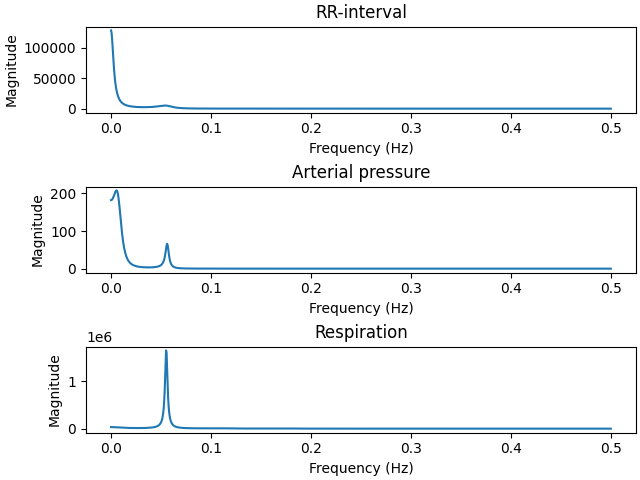

In [12]:
with open(fhr2, 'r') as f:
    txt = f.readlines()
    txt = [s[:-1].split() for s in txt]
    
    rr2 = np.array([float(s[0]) for s in txt])
    bp2 = np.array([float(s[1]) for s in txt])
    rs2 = np.array([float(s[2]) for s in txt])
    
y = [rr2, bp2, rs2]
ttl = ['RR-interval', 'Arterial pressure', 'Respiration']
    
plt.figure(constrained_layout=True)

for k in range(3):

    py, f = ar_psd(y[k], 15, 1.0)

    plt.subplot(3,1,k+1)
    plt.plot(f, py)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title(ttl[k])

    # Adjust the vertical spacing between subplots
    plt.subplots_adjust(hspace=0.8) 


**Question 1.5.** Repeat the processing steps done for `heart_1.dat` to obtain a parametric spectral estimation (order 15). Which of the physiological mechanisms described for the RR-interval was most disrupted by alcohol? And what other changes do you observe in the physiological signals?

**Answer 1.5.** `Computing a model of order 15 with data after alcohol consumption we see that for all the three data, i.e. RR-interval, arterial pressure and respiration, the frequency peaks decreased in frequency. In particular, 0.08 Hz and  0.225 Hz peaks in RR-interval have disappeared, meaning that the regulation of the baroreflex and the sinus arrhythmia have been compromised by alcohol. Moreover, the arterial pressure and the respiration decreased a lot in their frequency. We can suppose that this result is a consequence of the alcohol inhibition effect on the parasympathetic system. This inhibition leads to a slowdown of the respiration and arterial pressure. `

### Experiment 2: estimating the effects of fatigue on muscle signals
The files `/data/emg1.dat` and `/data/emg2.dat` contain three surface electromyography (sEMG) signals each (1024 Hz sampling frequency). These signals were recorded from the thigh muscle during a 10-min exercise on an ergocycle, respectively from an athlete (`emg1`) and from a moderately trained subject (`emg2`). In each file, the columns correspond to recordings from the *start*, *middle* and *end* of the exercise, respectively.

We start by importing the signals:

In [13]:
with open(fem1, 'r') as f:
    txt = f.readlines()
    txt = [s[:-1].split() for s in txt]
    
    n = len(txt)
    em1 = np.zeros((n,3))
    for k in range(3):
        em1[:,k] = [float(s[k]) for s in txt]

with open(fem2, 'r') as f:
    txt = f.readlines()
    txt = [s[:-1].split() for s in txt]
    
    n = len(txt)
    em2 = np.zeros((n,3))
    for k in range(3):
        em2[:,k] = [float(s[k]) for s in txt]

fs = 1024.0 # Hz

We first plot the sEMG segments in the time domain. We can observe four bursts in each recording, which correspond to four pedal strokes. The goal of the experiment was to assess the effects of fatigue on the signal properties of the sEMG.

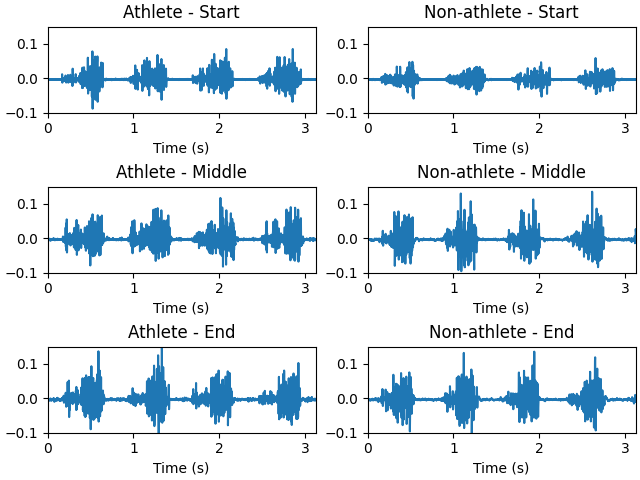

In [14]:
ttl1 = ['Athlete', 'Non-athlete']
ttl2 = ['Start', 'Middle', 'End']
t = np.arange(n) / fs

plt.figure(constrained_layout=True)
for k in range(2):
    
    y = [em1, em2][k]
    
    for l in range(3):
        
        plt.subplot(3,2,2*l+k+1)
        plt.plot(t,y[:,l])
        plt.xlim(t[0], t[-1])
        plt.ylim(-0.10, 0.15)
        plt.xlabel('Time (s)')
        plt.title(ttl1[k] + ' - ' + ttl2[l])

We'll now look at the spectral profile of the signals. Considering, for instance, the start sEMG recording of the athlete, we obtain the parametric power spectral density (PSD) for an AR model of order 30:

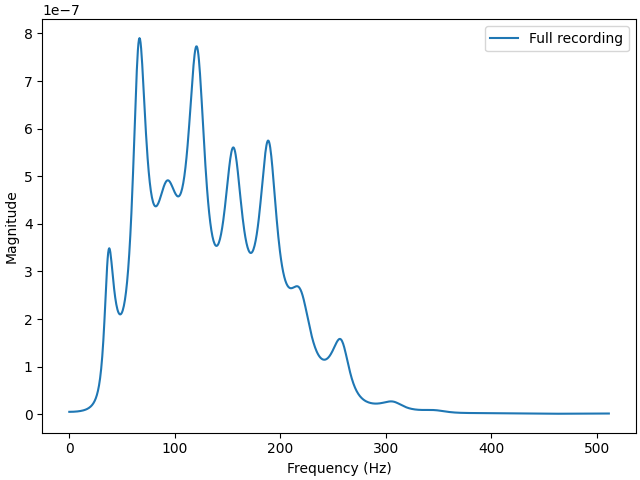

In [15]:
p = 30
pya, fa = ar_psd(em1[:,0], p, fs)

plt.figure(constrained_layout=True)
plt.plot(fa, pya, label='Full recording')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend()

**Question 2.1.** In principle, it would be more correct to segment each burst and analyze it separately, but it turns out that using the entire recording will yield a relatively similar spectral profile. Check that it is the case: copy the plotting code above to the space below and add (overlayed in the same panel) the PSD obtained from the first burst only, for the same signal. How do their profiles compare? Where does the difference in peak signal-to-noise come from?

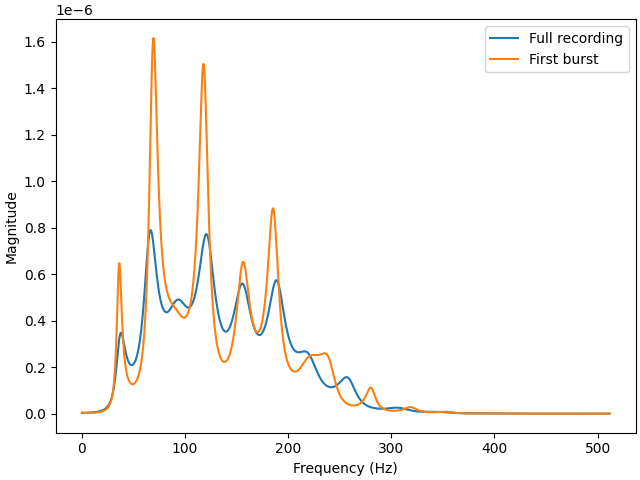

In [16]:
# **Answer 2.1.** 
# Calculate PSD for the first burst
start_time = 0  # Start time of the first burst
end_time = 0.7  # End time of the first burst
start_sample = int(start_time * fs)
end_sample = int(end_time * fs)
pya_first_burst, fa_first_burst = ar_psd(em1[start_sample:end_sample, 0], p, fs)

# Plot both PSDs in the same panel
plt.figure(constrained_layout=True)
plt.plot(fa, pya, label='Full recording')
plt.plot(fa_first_burst, pya_first_burst, label='First burst')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend()

#We see that both spectral profiles look alike, since they exhibit the peaks and the same frequencies. However, the PSD of the first burst shows a higher 
#peak of singal-to-noise, and this is due to several reasons: it could be that at the first burst there is no fatigue accumulated, so it doesn't have fatigue-related changes
#that the full recording may yield. In addition, we know that the full recording covers the whole signal, with burst and rest periods. These rest periods, that the first burst
#recording doesn't contain, could cause the full recording amplitude to be lower. 

We now estimate and plot the PSD for every recorded segment of both individuals:

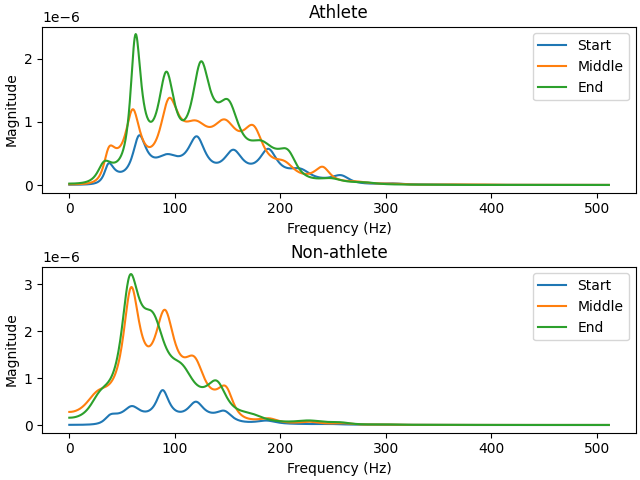

In [17]:
plt.figure(constrained_layout=True)
for k in range(2):
    
    y = [em1, em2][k]
    plt.subplot(2,1,k+1)
    
    for l in range(3):
        
        pya, fa = ar_psd(y[:,l], p, fs)
        plt.plot(fa, pya, label=ttl2[l])
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
    
    plt.title(ttl1[k])
    plt.legend()

**Question 2.2.** To complement the above PSD's, estimate the mean frequency using `sum(fa * pya / sum(pya))`. What does this formula express?

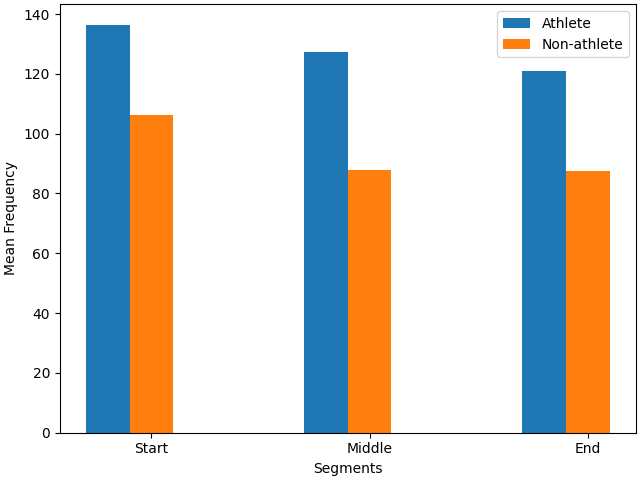

In [18]:
# **Answer 2.2.** `Write your answer here`
# Calculate mean frequencies as shown in the previous code
mean_frequencies = []

for k in range(2):
    y = [em1, em2][k]
    for l in range(3):
        pya, fa = ar_psd(y[:,l], p, fs)
        # Calculate the mean frequency using the formula
        mean_frequency = np.sum(fa * pya) / np.sum(pya)
        mean_frequencies.append(mean_frequency)

# 'mean_frequencies' now contains the mean frequency for each segment

segments_labels = ['Start', 'Middle', 'End']
individuals_labels = ['Athlete', 'Non-athlete']

# Arrange the mean frequencies in a format suitable for plotting
mean_frequencies_array = np.array(mean_frequencies).reshape(2, 3)

# Create a bar plot
plt.figure(constrained_layout=True)
x = np.arange(len(segments_labels))

for i in range(len(individuals_labels)):
    plt.bar(x + i * 0.2, mean_frequencies_array[i, :], width=0.2, label=individuals_labels[i])

# Set the x-axis ticks and labels
plt.xticks(x + 0.2, segments_labels)

# Set axis labels and legend
plt.xlabel('Segments')
plt.ylabel('Mean Frequency')
plt.legend()

# Show the plot
plt.show()


#The formula represents a weighted mean of frequency values, with the weights determined by power spectral density values. In essence, it computes the center of mass or weighted average of frequency components, 
#factoring in the influence of each frequency component on the overall signal power.This weighted mean serves as a compact summary of dominant frequencies, valuable for analyzing changes in muscle activity or 
#signal characteristics within different segments.


**Question 2.3.** Based on the PSD plots and the mean frequencies obtained above, what marks the difference between the athlete and the moderately trained subject?

**Answer 2.3.** `As expected, the athlete has less fatigue than the moderately trained subject. On the PSD plots we see that the power of the athlete has a smaller amplitude than that of the moderately trained subject; however, this is due to the fact that it has the power distributed in a wider range of frequencies. We observe that the athlete has a higher mean frequency and that it maintains it throughout the three parts, unlike the other subject who drops it already in the middle stage because the muscles are already tired. `

### Experiment 3: assessment of PPG signal structure
Photoplethysmography (PPG) is a simple, low-cost, non-invasive optical monitoring technique that can be used to detect volumetric changes in blood in the peripheral circulation, by measuring on the skin surface. It can be integrated in wearable devices (e.g. a watch) to monitor a person’s heart rate throughout daily life, and detect potential issues like atrial fibrillation. The file `/data/ppg.dat` contains a PPG recording from a normal cardiac rhythm, and another from a subject in atrial fibrillation (both sampled at 21.3 Hz).

We start by importing and plotting the two signals:

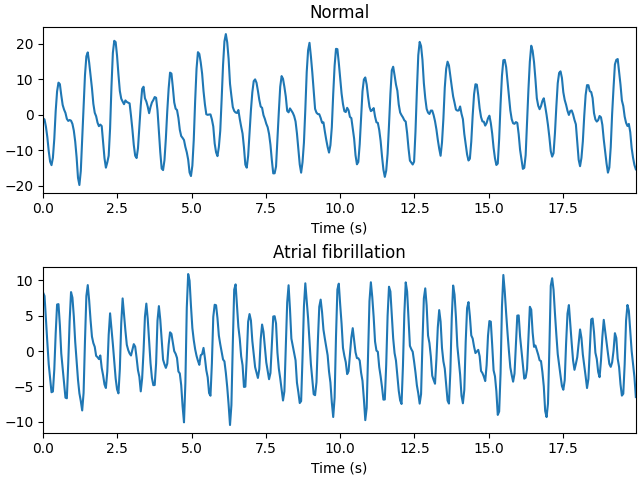

In [19]:
with open(fppg, 'r') as f:
    txt = f.readlines()
    txt = [s[:-1].split() for s in txt]
    
    ppg1 = np.array([float(s[0]) for s in txt])
    ppg2 = np.array([float(s[1]) for s in txt])

for y in [ppg1, ppg2]:
    y -= np.mean(y)

fs = 21.3 # Hz

plt.figure(constrained_layout=True)
ttl = ['Normal', 'Atrial fibrillation']

n = len(ppg1)
t = np.arange(n) / fs

for k in range(2):
    
    y = [ppg1, ppg2][k]
    
    plt.subplot(2,1,k+1)
    plt.plot(t, y)
    plt.xlim(t[0], t[-1])
    plt.xlabel('Time (s)')
    plt.title(ttl[k])

Each observed oscillation on the PPG typically corresponds to one pulse, generated by one cardiac cycle. By inspecting the plot above, we can already appreciate how one signal is visibly less regular than the other. AR modeling allows us to quantify the underlying differences with several complementary metrics.

We define again the function `ar_order` introduced in the previous practical session:

In [23]:
def ar_order(x, omax, Aff=0):
    """
    AR order estimation
    x: signal
    omax: maximum possible order
    Aff: 0 no graphic display; 1 display
    
    Returns:
    omdl: order estimated with MDL
    """
    
    nx = len(x)
    s = np.zeros((omax,))
    c = np.zeros((omax,))

    for k in range(omax):
        
        n = k+1
        
        ar_model = AutoReg(x, n, trend='n')
        ar_model_fit = ar_model.fit()
        sg2 = ar_model_fit.sigma2
        
        s[k] = sg2
        c[k] = nx * np.log(sg2) + (n+1) * np.log(nx)

    if Aff == 1:
        plt.figure()
        plt.plot(range(1, omax+1), c, 'o-')
        plt.title('Criterion')
        plt.show()
        
    return np.argmin(c)+1, s, c

**Question 3.1.** Estimate the optimal AR model order for each signal, using the function `ar_order` above (you can set a maximal order of 40 for the search).

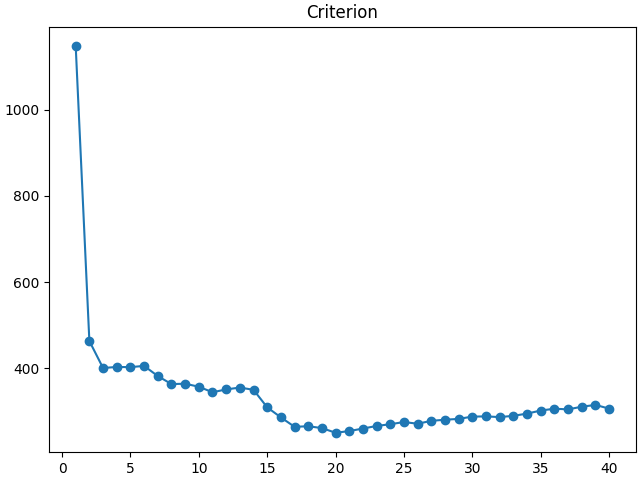

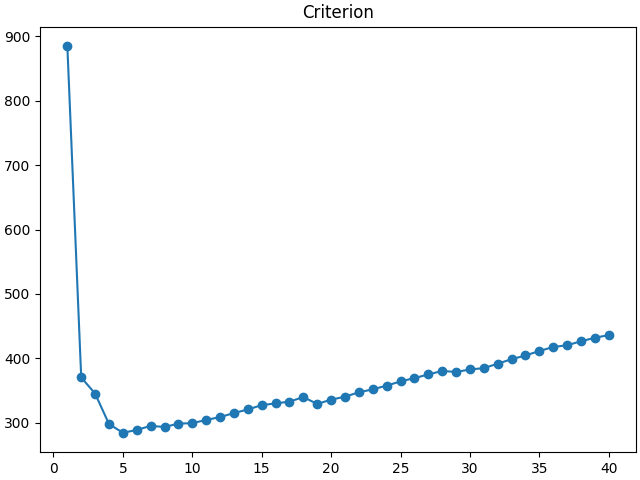

20 is the optimal order for describing the normal heartbeat
5 is the optimal order for describing the patient with atrial fibrillation heartbeat


In [24]:
#**Answer 3.1.** 
from statsmodels.tsa.api import AutoReg
def ar_order(x, omax, Aff=0):
    """
    AR order estimation
    x: signal
    omax: maximum possible order
    Aff: 0 no graphic display; 1 display
    
    Returns:
    omdl: order estimated with MDL
    """
    
    nx = len(x)
    s = np.zeros((omax,))
    c = np.zeros((omax,))

    for k in range(omax):
        
        n = k+1
        
        ar_model = AutoReg(x, n, trend='n')
        ar_model_fit = ar_model.fit()
        sg2 = ar_model_fit.sigma2
        
        s[k] = sg2
        c[k] = nx * np.log(sg2) + (n+1) * np.log(nx)

    if Aff == 1:
        plt.figure(constrained_layout = True)
        plt.plot(range(1, omax+1), c, 'o-')
        plt.title('Criterion')
        plt.show()
        
    return np.argmin(c)+1, s, c

min_normal, s_normal, c_normal = ar_order(ppg1, 40, 1)
min_atrial, s_atrial, c_atrial = ar_order(ppg2, 40, 1)

print(min_normal, "is the optimal order for describing the normal heartbeat")

print(min_atrial, "is the optimal order for describing the patient with atrial fibrillation heartbeat")

#For the normal heartbeat signal (ppg1), 20 is the optimal AR model order. Then for the atrial fibrillation signal, the parameter is equal to 5 (ppg2).


**Question 3.2.** Estimate the ratio between the excitation variance and the signal variance, for each signal (as in previous exercises, you can rely on the `yule_walker` function with `method='mle'`)

In [22]:
#**Answer 3.2.**
_, sigma = yule_walker(ppg1, order = 20, method = 'mle')
arr_normal = sigma**2 / np.var(ppg1)
print("The ratio for the normal heartbeat, signal ppg1, is: " , arr_normal)

_,sigma_atrial = yule_walker(ppg2, order = 5, method = 'mle')
arr_atrial = sigma_atrial**2 / np.var(ppg2)
print("The ratio for the fibrullar atrial heartbeat, signal ppg2, is: " , arr_atrial)


The ratio for the normal heartbeat, signal ppg1, is:  0.027664189552699937
The ratio for the fibrullar atrial heartbeat, signal ppg2, is:  0.10872695890695401


**Question 3.3.** Estimate and plot the PSD of each signal, using the `ar_psd` function for the estimates (for consistency, use the same order of 20 for both signals)

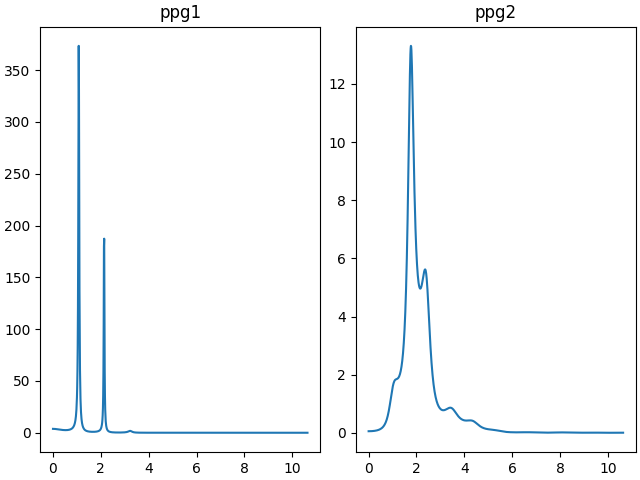

In [25]:
#**Answer 3.3.**
signal_ppg1, interval_ppg1 = ar_psd(ppg1, 20, 21.3)
signal_p2, interval_p2 = ar_psd(ppg2, 20, 21.3)

plt.figure(constrained_layout = True)
#plt.subplot(interval_ppg1 , signal_ppg1,1)
#plt.subplot(interval_p2, signal_p2,2)
plt.subplot(1,2,1)
plt.plot(interval_ppg1 , signal_ppg1)
plt.title('ppg1')
plt.subplot(1,2,2)
plt.plot(interval_p2, signal_p2)
plt.title('ppg2')
plt.show()

#This means that the energy is dissipated in multiple frequences for the atrial fibrillation. We can see this comparing to the normal one, where it has two clear pekas, indicating the structure of the signal with two defined frequencies.

**Question 3.4.** Estimate the entropy of the PSD of each signal, using:

*p = py / sum(py)*

*entropy = sum(-p * log(p))*

where py is the vector of PSD amplitudes.

In [26]:
#**Answer 3.4.**
#p = py / sum(py)
#entropy = sum(-p * log(p))
#where py is the vector of PSD amplitudes.


p_1 = signal_ppg1/np.sum(signal_ppg1)
entropy_1 = np.sum(-p_1 * np.log(p_1))
print("the entropy for the normal cardiac beating is:", entropy_1)


p_2 = signal_p2/np.sum(signal_p2)
entropy_2 = np.sum(-p_2 * np.log(p_2))
print("The entropy for the patient with atrial fibrillation is: ", entropy_2)


the entropy for the normal cardiac beating is: 4.006964138961618
The entropy for the patient with atrial fibrillation is:  5.503515070109581


**Question 3.5.** What do these measures (model order, variance ratio, PSD, entropy) tell us about the two signals? Interpret what you have obtained in terms of signal structure/organization.

**Answer 3.5.** `In general, we obtained results that reflect a more regular and organized signal structure for the normal case, as expected.
In particular, we calculated an AR model order of 20 for the normal heartbeat and 5 for the atrial fibrillation heartbeat. A higher-order model also means a higher accuracy of the model prediction: in our case, the normal model shows a more regular behavior, which may require a higher AR model order to capture its more stable and periodic dynamics. On the other hand, the atrial fibrillation signal shows an irregular behavior that is difficult to predict. It is associated with a lower model order, which indicates an inaccurate prediction.
Regarding the variance ratio, the fibrillar atrial heartbeat is higher than that of the normal ratio. The irregularity of the atrial fibrillation signal can introduce a significant amount of noise and variability into the PPG signal, which is translated in a higher variance ratio compared to a normal situation.
PSD for the normal signal has two well-distinct peaks, one corresponding to the heart pulse and the second one corresponding to the second harmonic. On the contrary, in atrial fibrillation, these peaks overlap each other, and we see a lack of well-defined heart rate. It shows that the heartbeat does not work at regular frequencies, and then the electric behavior of the heart is compromised.
Finally, the entropy measurements show smaller values for normal cardiac beating than for atrial fibrillation. It means that this latter has more disorder, more uncertainty, and more random components. This behavior is typical of arrhythmia as the atrial fibrillation.
`

### Experiment 4: Pisarenko harmonic estimation of brain signals
The file `/data/eeg_stim.dat` contains three recordings of scalp electroencephalography (EEG; left frontal electrode, 4-s duration, 512 Hz sampling frequency) from a Parkinson's patient. The patient was also implanted with a deep brain stimulation (DBS) electrode. The first recording corresponds to a baseline (rest) state, the second was obtained during 1-Hz stimulation, and the third during 100-Hz stimulation.

We start by importing and plotting the three signals:

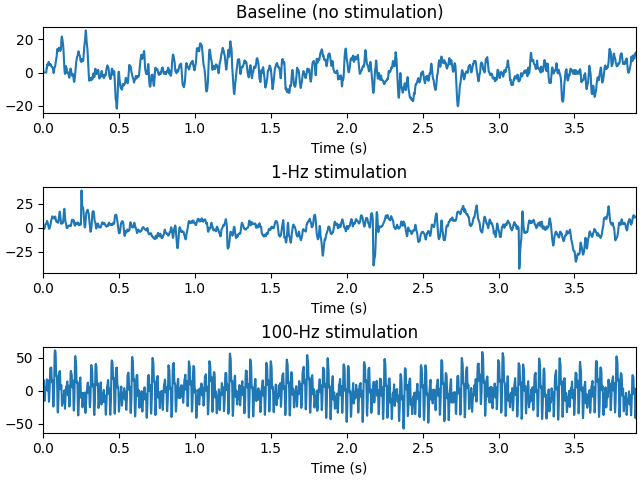

In [27]:
with open(feeg, 'r') as f:
    txt = f.readlines()
    txt = [s[:-1].split() for s in txt]
    
    n = len(txt)
    eeg = np.zeros((n,3))
    for k in range(3):
        eeg[:,k] = [float(s[k]) for s in txt]

fs = 512.0 # Hz

plt.figure(constrained_layout=True)
ttl = ['Baseline (no stimulation)', '1-Hz stimulation', '100-Hz stimulation']

t = np.arange(n) / fs

for k in range(3):
    plt.subplot(3,1,k+1)
    plt.plot(t, eeg[:,k])
    plt.xlim(t[0], t[-1])
    plt.xlabel('Time (s)')
    plt.title(ttl[k])

**Question 4.1.** Visually, does any of the stimulation strategies appear to have an effect on the EEG? Which one(s)?

**Answer 4.1.** `Visually, it appears that the first two plots (Baseline and 1-Hz) are mostly stochastic and disordered compared to the 100 Hz stimulation that presents a seemingly much more structured behaviour. This would imply that the third stimulation (100 Hz) is the only one to have had an effect on the measured EEG signal.`

Text(0.5, 1.0, 'Autocorrelation of eeg 100Hz')

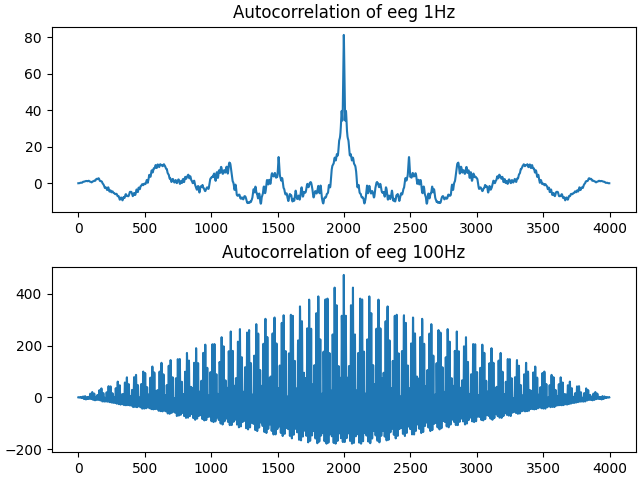

In [29]:
#this is just out of curiosity to play around with the autocorrelation and see the difference
#between the Pisarenko method and just autocorrelation
from scipy.signal import correlate
rx=correlate(eeg[:,1], eeg[:,1], mode='full', method='auto') / len(eeg[:,1])
rx100=correlate(eeg[:,2], eeg[:,2], mode='full', method='auto') / len(eeg[:,2])

#columns = rx.shape

# print(f"The autocorrelation has {columns} values")
# print(f"The signal has {len(eeg[:,1])} data values")
# should be 2*number of data points -1 since the autocorrelation involves
# shifting the signal positively AND negatively (positive and negative lags)
# doubling the "size". The -1 is because we don't count 0th sample twice.

fig = plt.figure(constrained_layout=True)
plt.subplot(2,1,1)
plt.plot(rx)
plt.title('Autocorrelation of eeg 1Hz')
plt.subplot(2,1,2)
plt.plot(rx100)
plt.title('Autocorrelation of eeg 100Hz')


As in previous examples, we can apply modeling techniques to quantify the physiological effects under study. Because the DBS is applied in a periodic regime with a specific frequency, it is reasonable to expect a strong sinusoidal presence on the EEG recordings, for any cases where the stimulation does produce a measurable effect. This motivates applying the Pisarenko harmonic retrieval approach, which is implemented below:

In [30]:
def pisarenko(x, p, fs, Aff=0):
    """
    Pisarenko method for harmonic retrieval
    
    x: signal
    p: number of sinusoids
    fs: sampling frequency
    Aff: 0 no graphic display; 1 display
    
    f: vector of sinusoid frequencies
    pp: vector of sinusoid amplitudes
    sg2: noise variance
    
    """
    
    n = len(x)
    
    rx = correlate(x, x, mode='full', method='auto') / n
    
    rxx = np.zeros((2*p+1,2*p+1))
    for k1 in range(2*p+1):
        for k2 in range(2*p+1):
            rxx[k1,k2] = rx[n-1 + abs(k1 - k2)]
    
    u, v = np.linalg.eig(rxx)
    
    sg2 = np.min(u)
    vm = v[:,np.argmin(u)]  # get eigenvector from smallest eigenvalue
    
    r = np.roots(vm)  # find roots of the polynomial
    f = np.angle(r) / (2*np.pi)  # get angle and convert to Hz/sample
    f = f[f > 0]
    
    # Amplitude estimation
    aa = np.zeros((p, len(f)))
    for k in range(p):
        aa[k,:] = np.cos(2*np.pi * (k+1) * f)
    
    r = rx[n:n+p]
    
    pp = np.linalg.lstsq(aa, r, rcond=None)[0]
    f *= fs
    
    if Aff:
        
        plt.figure(constrained_layout=True)
        
        plt.subplot(2,1,1)
        plt.plot(np.arange(1,n+1) / fs, x)
        plt.xlabel('Time (s)')
        plt.title('Signal')
        
        plt.subplot(2,1,2)
        plt.plot([0, fs/2], [sg2, sg2], linewidth=2)
        for k in range(p):
            plt.plot([f[k], f[k]], [sg2, sg2+pp[k]], linewidth=2)
        plt.axis([0, fs/2, 0, 1.2 * (np.max(pp) + sg2)])
        plt.xlabel('Frequency (Hz)')
        plt.title('Pisarenko spectrum')
    
    return f, pp, sg2

**Question 4.2.** Using the above function, apply the Pisarenko method with 5 sinusoids to each of the three recordings, and report the estimated parameters (frequencies, amplitudes, excitation variance).

1) We will first apply the pisarenko method for each case and then round the values of the obtained frequencies to 2 decimal places as this will facilitate readability

/tmp/ipykernel_85/1795192645.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(constrained_layout=True)


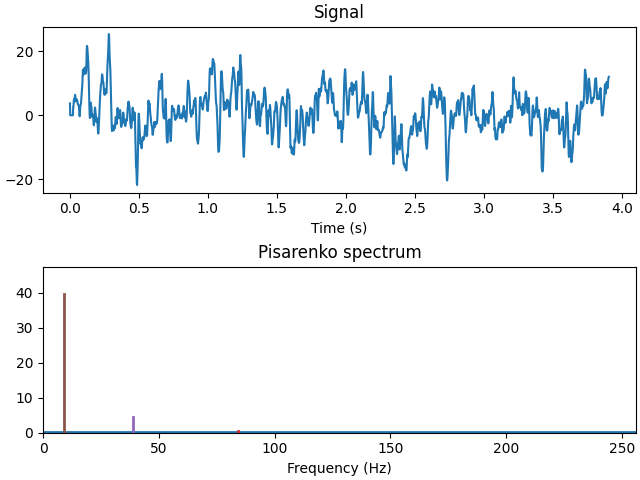

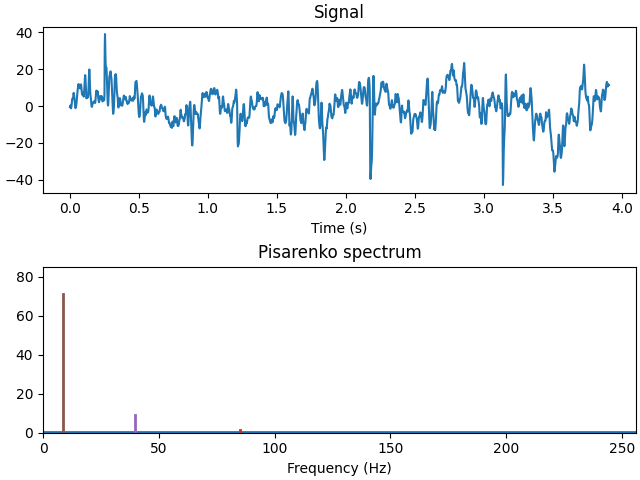

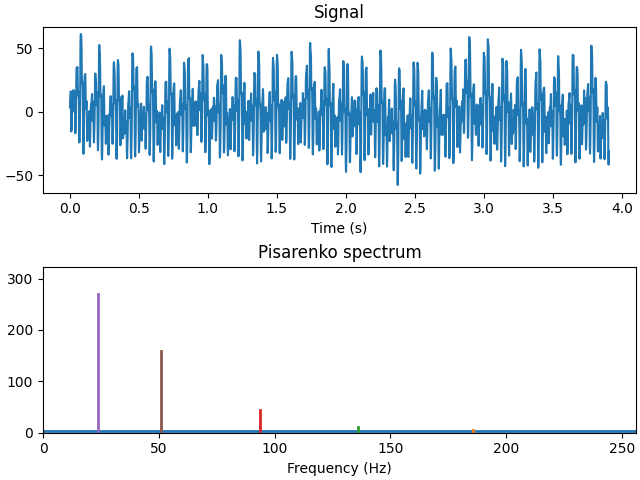

In [31]:
freqBase,ampBase,exvarBase=pisarenko( eeg[:,0], 5, 512, Aff=1)
freq1,amp1,exvar1=pisarenko( eeg[:,1], 5, 512, Aff=1)
freq100,amp100,exvar100=pisarenko( eeg[:,2], 5, 512, Aff=1)


#rounding the values obtained for clairty
decimals=2
freqBase_round=np.round(freqBase,decimals )
freq1_round=np.round(freq1, decimals )
freq100_round=np.round(freq100, decimals )
ampBase_round=np.round(ampBase, decimals ) 
amp1_round=np.round(amp1, decimals )
amp100_round=np.round(amp100,decimals )
exvarBase_round=np.round(exvarBase, decimals )
exvar1_round=np.round(exvar1, decimals )
exvar100_round=np.round(exvar100, decimals )


**Answer 4.2.** `A table will be used to display the data as this should make comparison more straightforward:`

In [32]:
#creating a table to showcase the data 
import pandas as pd

data = {
    'Estimated Frequencies (Hz)': [freqBase_round, freq1_round, freq100_round],
    'Amplitude of each frequency': [ampBase_round, amp1_round, amp100_round],
    'Noise Variance': [exvarBase_round, exvar1_round, exvar100_round]
}
pd.set_option('display.max_colwidth', None)


# Create the DataFrame
df = pd.DataFrame(data)
df.index = ['Baseline', '1 Hz Stimulation', '100 Hz Stimulation']

# To display the table
df


,Estimated Frequencies (Hz),Amplitude of each frequency,Noise Variance
Baseline,"[177.97, 130.1, 84.36, 38.89, 9.02]","[0.01, 0.06, 0.39, 4.33, 39.63]",0.03
1 Hz Stimulation,"[181.14, 132.83, 85.03, 39.61, 8.73]","[0.03, 0.16, 1.05, 9.02, 70.99]",0.06
100 Hz Stimulation,"[185.89, 136.09, 93.57, 23.54, 50.79]","[1.34, 7.67, 39.28, 265.73, 154.96]",3.76


The above table reports the estimated Pisarenko spectrum for each of the cases, along with their respective  magnitudes and the variance of the excitation noise. 

The frequencies are listed by increasing magnitude.


**Question 4.3.** Interpret the estimation results -- which stimulation frequency appears to effectively influence brain activity?

**Answer 4.3.** `From the table it is more clear that the baseline case and the 1 Hz stimulation share almost identical frequencies, with only a noticeable change in the lowest frequency amplitude. The noise variance is also very similar and low.

The slight increase in amplitude of the (approximately) 9 Hz frequency common to both the 1 Hz stimulated state and the baseline, while "noticeable", could just be an effect of the 1Hz DBS stimulation frequency that is being picked up and introduced as noise or additional "power" in the low frequencies of the brain, without necessarily changing the brain activity. 

This means that the 1Hz stimulation effectively shows no difference in brain activity: the frequencies present are the same and so are their intensities. 

However, regarding the 100 Hz stimulation, the story is different. Firstly, the amplitudes of the frequencies are noticeably much greater everywhere in the frequency range compared to the other two cases. In addition, while the frequencies at around 180 and 130 Hz are still present, it appears that the 85 Hz frequency has increased by almost 10 Hz! 

Furthermore the 40 Hz frequency has also shifted by 10 Hz but it has now become the weakest intensity frequency. The 9 Hz frequency has now become roughly 25 Hz and has a greater contribution than the 50 Hz one.

There is also more excitation noise variance.

In conclusion, the 100 Hz stimulation has shown to affect all the present brain frequencies as well as their intensity: i.e a change in brain activity compared to the baseline and 1 Hz stimulation.
`

### Have a good session, and don't hesitate to ask questions!